# Project 3: Term Deposit Marketing Campaign

The objective in this case study is to build a predictive model that a bank can then use to identify customers who are likely to subscribe to a certificate of deposit (CD). The bank's marketing team can then use the predictive model to focus their marketing efforts and thus improve their hit ratio. 

The following steps will need to be accomplished in order to deliver this objective:
1. [Import the dataset and libraries](#1)
2. [Perform Exploratory Data Analysis to gain insights in the data](#2)
3. [Data Preprocessing](#3)
4. [Build Logistic Regression and Decision Tree Models](#4)
5. [Build Ensemble Models (Bagging, AdaBoosting, and Gradient Boosting)](#5)

<a id="1"></a>
### Step 1: Import the dataset and libraries

In this section we will first load all of the nessecary libraries. Next we will load the dataset noting how many records there are, identifying the data types present, and checking for missing values.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization defaults
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# statistical packages
from scipy.stats import boxcox, skew

# models used in this analysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# model helpers
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2

# model performance measure
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,confusion_matrix, roc_curve, auc


C:\Users\dhick\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# load the data as pandas dataframe
data = pd.read_csv("bank-full.csv")

In [3]:
# verify that the data loaded correctly
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# get the number of rows and columns of the data
print("There are {} rows and {} columns in the dataset.".format(data.shape[0],data.shape[1]))

There are 45211 rows and 17 columns in the dataset.


***Description of Features***

    Bank client data:
        1. age (continuous)
        2. job (nominal): Type of job (management, technician, entrepreneur, blue-collar, etc.)
        3. marital (nominal): marital status (married, single, divorced)
        4. education (ordinal): education level (primary, secondary, tertiary)
        5. default (binary): has credit in default?
        6. housing (binary): has housing loan?
        7. loan (binary): has personal loan?
        8. balance in account (continuous)
        
    Related to previous contact:
        9.  contact (nominal): contact communication type
        10. month (ordinal): last contact month of year
        11. day (ordinal): last contact day of the month
        12. duration (continuous): last contact duration, in seconds
        
    Other attributes:
        13. campaign (interval): number of contacts performed during this campaign and for this client
        14. pdays (interval): number of days that passed by after the client was last contacted from a previous campaign 
            (-1 tells us the person has not been contacted or contact period is beyond 900 days)
        15. previous (interval): number of times the client has been contacted before for the last campaign to 
            subscribe term deposit
        16. poutcome (ordinal): outcome of the previous marketing campaign
        
    Output variable (desired target):
        17. Target (binary): Tell us has the client subscribed a term deposit. (Yes, No)

In [5]:
# Using data.info(), we can inspect the various data types in our dataset and also check for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We have a collection of object and integer data types in the dataset. We can also see that every column, from age to Target, has 45,211 values implying there are no missing values. 

Before we dive into visualizing the data we will first assemble a data quality report, one for the numerical features and another for the categorical features. 

In [6]:
def categorical_data_report(dataframe):
    
    # Assemble a list categorical features
    categorical_features = []

    for feature in dataframe.columns: # Loop through all columns in the dataframe
        if dataframe[feature].dtype == 'object': # Only apply for columns with categorical strings
            categorical_features.append(feature)
            
    # create categorical data report using built in describe() method
    categorical_data_report = dataframe[categorical_features].describe().T
    
    # add a percent missing column
    categorical_data_report['% missing'] = dataframe[categorical_features].apply(lambda x: x.isna().mean())
    
    # add a mode percentage column
    categorical_data_report['mode %'] = 100*categorical_data_report['freq']/categorical_data_report['count']
    
    # rename columns
    categorical_data_report.rename(columns={'top':'mode','freq':'mode freq','unique':'cardinality'},inplace=True)
    
    # rearrange the columns
    categorical_data_report = categorical_data_report[['count','% missing','cardinality','mode','mode freq','mode %']]
    
    return categorical_features, categorical_data_report
    

In [7]:
def numerical_data_report(dataframe):
    
    from pandas.api.types import is_numeric_dtype
    
    # Assemble a list numerical features
    numerical_features = []
    for feature in dataframe.columns: 
        if is_numeric_dtype(dataframe[feature]):
            numerical_features.append(feature)
    
    # create numerical data report using built in describe() method
    numerical_data_report = dataframe[numerical_features].describe().T
    
    # add a percent missing column
    numerical_data_report['% missing'] = dataframe[numerical_features].apply(lambda x: x.isna().mean())
    
    # add a cardinality column
    numerical_data_report['cardinality'] = dataframe[numerical_features].apply(lambda x: x.nunique())
    
    # add a skew column
    numerical_data_report['skew'] = dataframe[numerical_features].apply(lambda x: x.skew())
    
    # rearrange the columns 
    cols = ['count','% missing','cardinality','mean','std','min','25%','50%','75%','max','skew']
    numerical_data_report = numerical_data_report[cols]
    
    return numerical_features, numerical_data_report
    

In [8]:
# assemble a data quality report for the categorical features
categorical_features, categorical_data = categorical_data_report(data)
categorical_data

,count,% missing,cardinality,mode,mode freq,mode %
job,45211,0.0,12,blue-collar,9732,21.5257
marital,45211,0.0,3,married,27214,60.1933
education,45211,0.0,4,secondary,23202,51.3194
default,45211,0.0,2,no,44396,98.1973
housing,45211,0.0,2,yes,25130,55.5838
loan,45211,0.0,2,no,37967,83.9774
contact,45211,0.0,3,cellular,29285,64.7741
month,45211,0.0,12,may,13766,30.4483
poutcome,45211,0.0,4,unknown,36959,81.7478
Target,45211,0.0,2,no,39922,88.3015


Several features catch our eye here: 
- First, and most importantly, is class imbalance in the Target. We see that out of all the term deposits that were offered 88.3% of them were declined.
- The extreme imbalance of the default feature (98.2%). We may want to consider removing this feature from the dataset. 
- The mode of poutcome is "unknown" with a frequency of 81.7%. This suggests that 81.7% of the observations for the outcome of the previous campaign were missing and simply reported as "unknown".

In [9]:
# assemble a data quality report for the numerical features
numerical_features, numerical_data = numerical_data_report(data)
numerical_data

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
age,45211.0,0.0,77,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818
balance,45211.0,0.0,7168,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308
day,45211.0,0.0,31,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079
duration,45211.0,0.0,1573,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318
campaign,45211.0,0.0,48,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650
pdays,45211.0,0.0,559,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715
previous,45211.0,0.0,41,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454


A few notable items that demand our attention:
- First is the minimum balance of -8,019. Perhaps this is valid if the person in question had overdrawn from their account. We would want check with the business and verify that negative balances are legitimate. This feature is also highly skewed to the right implying the presence of extreme outliers.
- Second is minimum value of -1 for pdays which reflects that the person was not contacted  or that the contact period is beyond 900 days since the last campaign. At least 75% of these observations are having this value.
- Third, and finally, is the extreme skewness of the "previous" feature. This skewness is so extreme that we should consider dropping this feature entirely.

In [10]:
data.Target = data.Target.map({'no':0, 'yes':1})

<a id="2"></a>
### Step 2: Exploratory Data Analysis
#### 2.1 Univariate Analysis

The data quality reports provide a high level overview of the data we will be using to train the models. They draw our attention to any immediate data quality issues i.e. missing values, irregular cardinality, imbalanced categorical features, extreme skewness, etc. In the following sections we will take a more in depth look at the data by supplementing the data quality report with stacked histograms and boxplots for the numerical features and countplots for the categorical ones.

<b style="color:blue;font-size:15px;">Numerical Features</b>

<b style="color:blue;font-size:15px;">Age and Day</b>

In [11]:
# data summary
numerical_data.loc[['age','day'],:]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
age,45211.0,0.0,77,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818
day,45211.0,0.0,31,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079


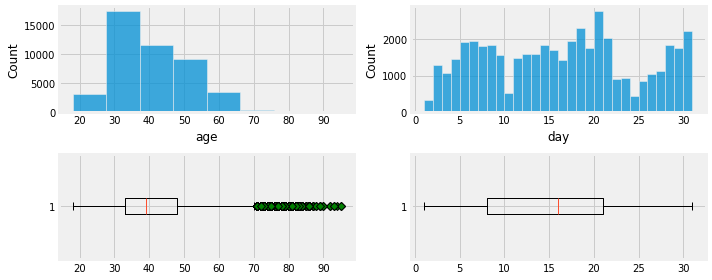

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

sns.histplot(data=data, x='age', bins=8, ax=axes[0,0]);
sns.histplot(data=data, x='day', binwidth=1, ax=axes[0,1]);
axes[1,0].boxplot(data['age'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['day'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

- Fairly symmetric distribution of ages with half of the observations falling between 33 and 48 years. We can see a few outliers for ages past 70 years. 
- Multimodal distribution for day. Contact occurs most frequently towards the end of each week. No outliers present in this feature.

<b style="color:blue;font-size:15px;">Campaign and Previous</b>

In [13]:
numerical_data.loc[['campaign','previous'],:]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
campaign,45211.0,0.0,48,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650
previous,45211.0,0.0,41,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454


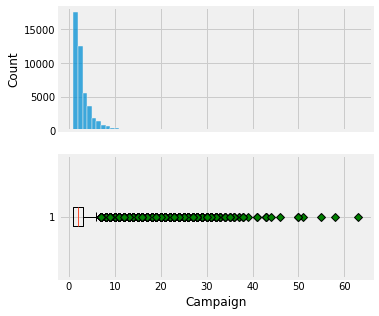

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
sns.histplot(data=data, x='campaign',binwidth=1, ax=axes[0]);
axes[1].boxplot(data['campaign'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.xlabel("Campaign");

- The campaign feature is exhibits the behavior of an exponential distribution. There are quit a few outliers present in this feature. The maximum contacts made was 63 which seems excessive but probably valid. There is a significant amout of skewness in this feature due to these outliers.
- The skewness in the previous feature is so extreme that we will be dropping this feature

In [15]:
# dropping the "previous" feature due to extreme skewness
data.drop(columns='previous', inplace=True)

# remove "previous" from teh numerical_features list
numerical_features.remove('previous')

<b style="color:blue;font-size:15px;">Balance and Pdays</b>

In [16]:
numerical_data.loc[['balance','pdays'],:]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
balance,45211.0,0.0,7168,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308
pdays,45211.0,0.0,559,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715


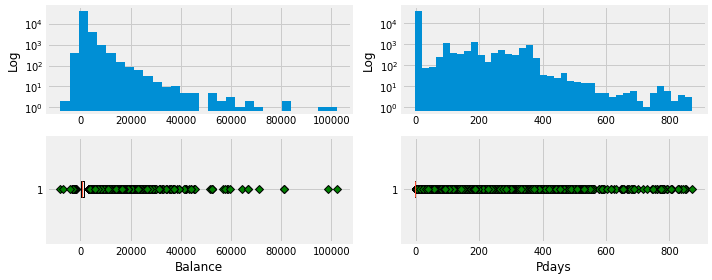

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

axes[0,0].hist(data['balance'], log=True, bins=30);
axes[0,0].set_ylabel("Log")
axes[1,0].boxplot(data['balance'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,0].set_xlabel("Balance")


axes[0,1].hist(data['pdays'], log=True, bins=40);
axes[0,1].set_ylabel("Log")
axes[1,1].boxplot(data['pdays'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].set_xlabel("Pdays")

plt.tight_layout()

- Balance is another highly right skewed feature, but this level of skewness is common for this kind of predictor.
- Most of the observations for "pdays" are -1 which implies that most of the pday observations were missing and have been replaced with -1. 

<b style="color:blue;font-size:15px;">Duration</b>

In [18]:
pd.DataFrame(numerical_data.loc['duration',:]).T

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
duration,45211.0,0.0,1573.0,258.16308,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318


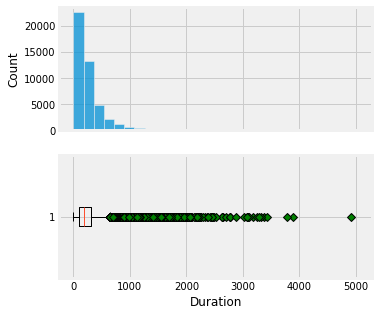

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
sns.histplot(data=data, x='duration', ax=axes[0], binwidth=180)
axes[1].boxplot(data['duration'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.xlabel("Duration");

- Another right skewed distribution. The median call time was 180 seconds (3 mins) and the maximum call time was 4,918 seconds (1.4 hrs). There are outliers here but all seem to be valid data. 
- According to the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#), from which this data was made available, duration "highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model." For this reason we will drop this feature from the dataset.

In [20]:
# dropping duration from the dataset
data.drop(columns='duration', inplace=True)

# remove duration from the list of numerical features
numerical_features.remove("duration")

<b style="color:blue;font-size:15px;">Categorical Features</b>

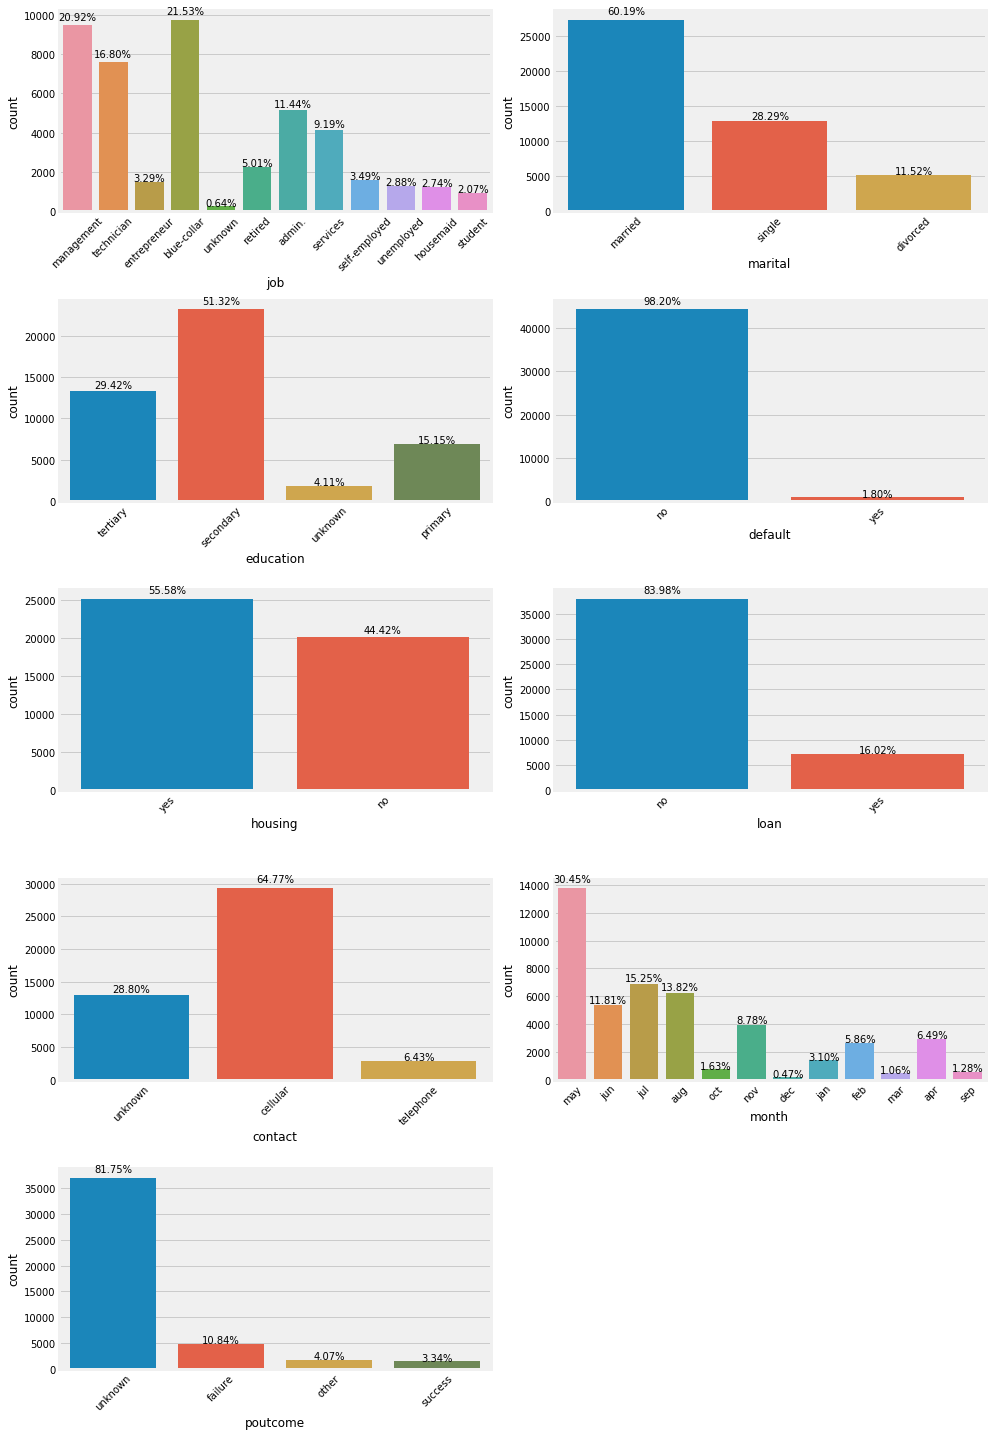

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(14, 20))

total = data.shape[0]

# create a countplot of the categorical features
for idx,feature in enumerate(categorical_features[:-1]): 
    ax=axes.flatten()[idx]
    sns.countplot(x=feature, data=data, ax=ax)
    
    # rotate axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    # add percentages above the bars 
    for p in ax.patches:
        width = p.get_x()+p.get_width()/2.
        height = p.get_height()
        ax.text(width, # x cordinate 
                height*1.03, # y coordinate 
                '{:1.2f}%'.format(height/total*100), # divide the bar height by the total
                ha="center")
axes[4,1].set_axis_off()
plt.tight_layout()

- 81.75% of the "poutcome" observations are reported as unknown implying most of the values were missing. Normally we should drop this column. However, knowing if someone had previously purchased a term deposit is valuable information as we will later see.
- 98.2% of observations in the default column are "no". This feature is not informative and will be dropped.
- 4.11% of the observations in the education feature are reported as unknown. These unknown values will be replaced by the mode (secondary)
- 0.64% of the observations in the job feature are unknown. These observations will be replaced with the mode (blue-collar)

In [22]:
# drop "default" column
data.drop(columns=['default'])

# replace unknown values with the mode of their respective columns
data.education.replace("unknown","secondary", inplace=True)
data.job.replace("unknown","blue-collar", inplace=True)

#### 2.1 Multivariate Analysis

<b style="color:blue;font-size:15px;">Numerical Features</b>

First we will check for any colinearity between the numerical predictors and check their correlation with the Target.

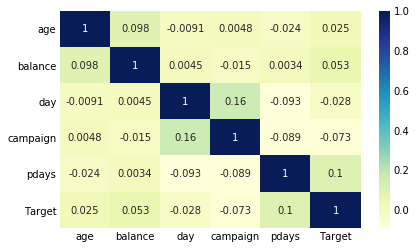

In [23]:
corr_df = data[['age', 'balance', 'day', 'campaign', 'pdays','Target']].corr()
sns.heatmap(corr_df,  annot=True, cmap="YlGnBu");

No significant colinearity between these features nor is there any significat correlation with the Target. 

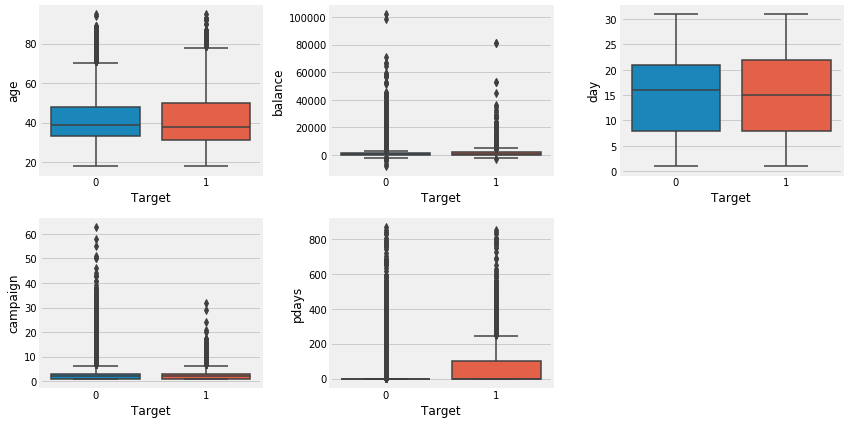

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx,feature in enumerate(numerical_features):
    sns.boxplot(x='Target',
                y=feature, 
                data=data, 
                ax=axes.flatten()[idx], 
                linewidth=1.5);

axes[1,2].set_axis_off()
plt.tight_layout()

On their own none of the numerical features cannot discriminate between the target levels. This is made evident by the lack of a difference in the central tendency and variation of the continuous feature across the different levels of the Target.

Perhaps they are more discriminative when they interact amounst themselves and the various categorical features. We will explore some of these intereations below.

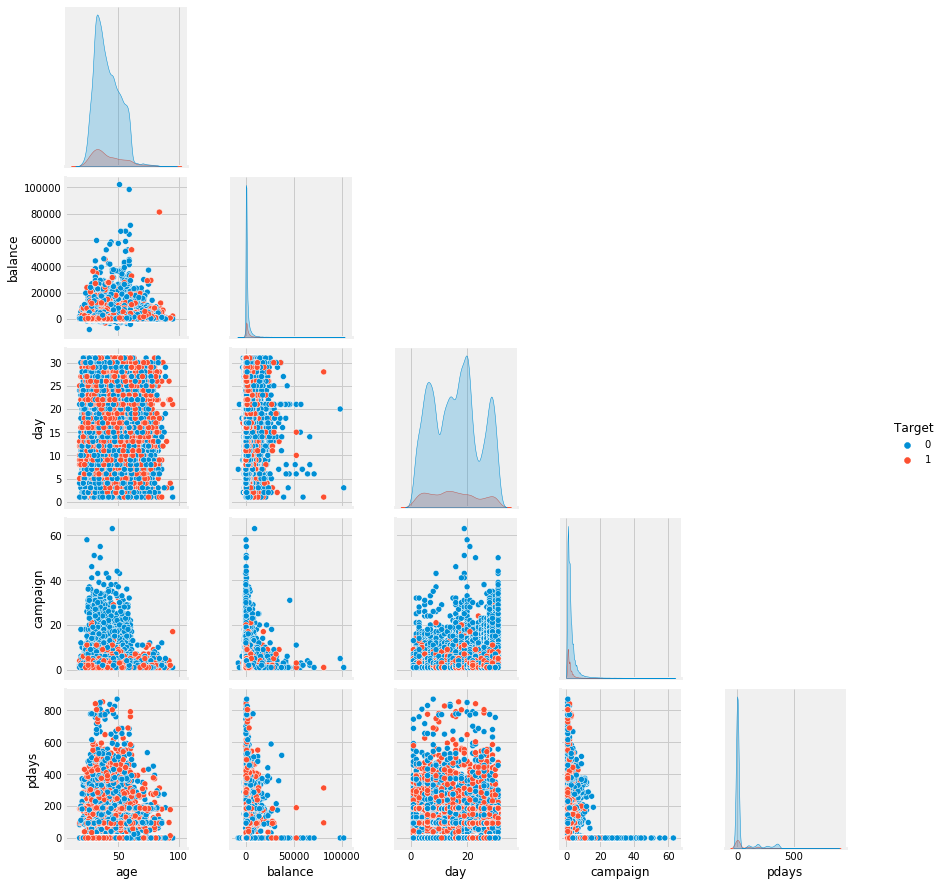

In [25]:
sns.pairplot(data, hue='Target', vars=numerical_features, corner=True);

No clear separation between the classes when looking at pairs of continuous features. 

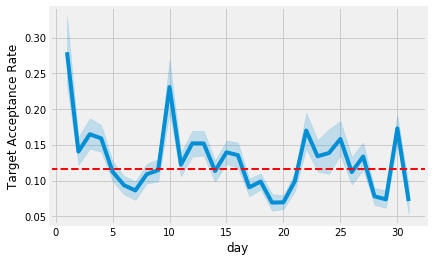

In [26]:
ref_line = data.Target.mean()
sns.lineplot(data=data, x='day', y='Target')
plt.axhline(y=ref_line, color='r', linestyle='--', linewidth=2)
plt.ylabel("Target Acceptance Rate")
plt.show()

The 1st and 10th are the best days of the month to offer term deposits.

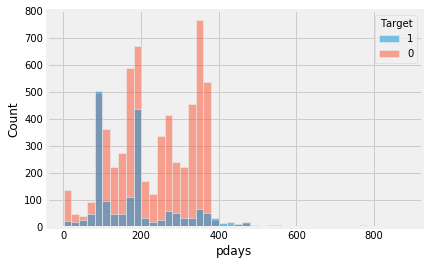

In [27]:
pdays_filter = data.pdays > -1
sns.histplot(data=data[pdays_filter], x='pdays', hue='Target', hue_order=[1,0], binwidth=20);

Setting the binwidth to 20 helps us to see that the acceptance rate jumps above 50% between 80 and 100 pdays. We also observe a healthy acceptance rate betweeen 180 and 200 pdays. Let's zone in on these date ranges and plot the acceptance rate versus pdays.

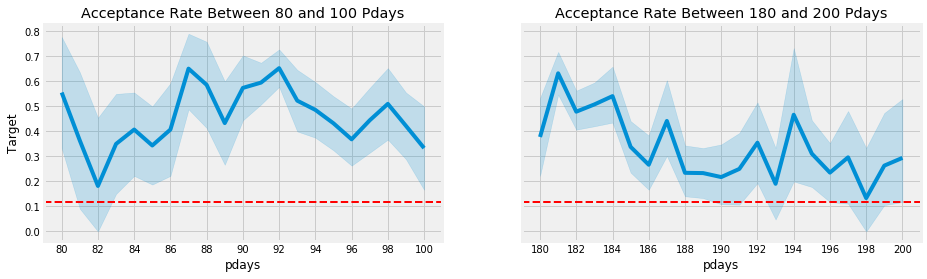

In [28]:
pdays_filter_1 = (data.pdays >= 80) & (data.pdays <= 100)
pdays_filter_2 = (data.pdays >= 180) & (data.pdays <= 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

sns.lineplot(x='pdays', y='Target', data=data[pdays_filter_1], ax=axes[0]);
axes[0].axhline(y=ref_line, color='r', linestyle='--', linewidth=2)
axes[0].set_title("Acceptance Rate Between 80 and 100 Pdays");
axes[0].xaxis.set_ticks(np.arange(80,101,2))

sns.lineplot(x='pdays', y='Target', data=data[pdays_filter_2], ax=axes[1]);
axes[1].axhline(y=ref_line, color='r', linestyle='--', linewidth=2)
axes[1].xaxis.set_ticks(np.arange(180,201,2))
axes[1].set_title("Acceptance Rate Between 180 and 200 Pdays");

In the first figure we can see the acceptance rate peak at 65% on pday 92 while in the second figure we see the acceptance rate peak at 63% at pday 181. We should communicate to the marketing team to contact their high priority customers at 90 and 180 days after the previous campaign.

<b style="color:blue;font-size:15px;">Categorical Features</b>

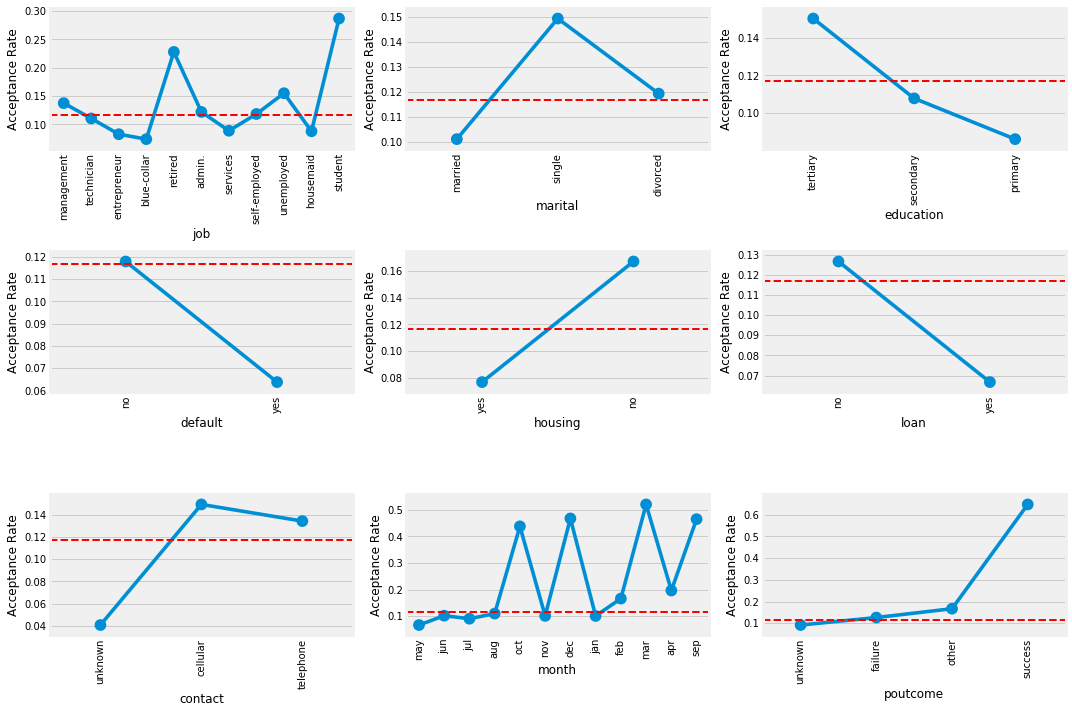

In [29]:
# prepare a figure that contains subplots for each nominal feature
fig, axes = plt.subplots(3, 3, figsize=(15, 10))


ref_line = data.Target.mean()

for idx,feature in enumerate(categorical_features[:-1]):
    
    ax = axes.flatten()[idx]
    
    # plot the data
    sns.pointplot(x=feature, y='Target', data=data, ax=ax, scale=0.5, ci=None);
    ax.set_ylabel('Acceptance Rate');
    ax.axhline(y=ref_line, color='r', linestyle='--', linewidth=2);
    
    # rotate x axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


plt.tight_layout()

- Most of the categorical variables are related to the response as is evident by the departure from the 11.7% acceptance rate accros the different levels of the variables. 
- Interestingly, people who are either retired or students are the most likely to accept a term deposit.
- Oct, Dec, MAr, and Sep are the best months to offer term deposits
- If someone has purchased a term deposit in a previous campaign there is a 65% chance that they will purchase another one in the next campaign.

<a id="3"></a>
# Step 3: Data Preprocessing
Before we can begin the modelling process we need to change our categorical features into numerical data types. For the ordinal features we will use label encoding where we map the different levels of a feature to an integer. For the nominal features we will use one-hot encoding. Once the encoding are complete we will split our data into training and test sets using a 70:30 split. Finally, we scale the data to fall with the range of [0, 1] using MinMaxScaler. 

### 3.1 Label Encoding the Oridinal Features

In [30]:
education_mapping = {'unknown':0, 'primary':1, 'secondary':2, 'tertiary':3 }
data.education = data.education .map(education_mapping)

month_mapping = {'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 
                 'dec':12, 'jan':1, 'feb':2,'mar':3, 'apr':4, 'sep':9}
data.month = data.month.map(month_mapping)

### 3.2 One-hot Encoding for Nominal Features

In [31]:
data = pd.get_dummies(data,drop_first=True)

### 3.3 Create Training and Test Splits

In [32]:
# create input feature array
X = data.drop(columns=['Target'])

# create prediction labels
y = data['Target']

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

### 3.4 Scale Input Data

In [33]:
# initialize minmax scaler
minmax_scaler = MinMaxScaler()

# Scale the training data to fall in the range [0,1]
X_train_scaled = minmax_scaler.fit_transform(X_train)

# Scale the test data
X_test_scaled = minmax_scaler.transform(X_test)

<a id="4"></a>
# Step 4: Logistic Regression and Decision Tree Models
We will begin by fitting two models, Logistic Regression and Decision Trees, to the training data. Once complete, we will visualize a confusion matrix for both models and comment on they're individual precision, recall, f1, and accuracy.

#### 4.1 Decision Tree

In [34]:
# max depth = 6
# initialize the decision tree classifier 
dt = DecisionTreeClassifier(random_state=1)

# fit the decision tree to the training data
dt.fit(X_train, y_train)

# make predictions using the test data
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1] # predicted class probabilites

print("Training score = {}".format(dt.score(X_train,y_train)))
print("Test score = {}".format(dt.score(X_test,y_test)))

Training score = 1.0
Test score = 0.8323503391329992


The difference between the training and test scores indicates overfitting which is common shortcoming of these types of models.

#### 4.2 Logistic Regression

In [35]:
# initialize the linear regression model
logreg = LogisticRegression(random_state=1)

# fit the linear regression model to the scaled training data
logreg.fit(X_train_scaled, y_train)

# make predictions using the scaled test data
y_pred_logreg = logreg.predict(X_test_scaled)
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1] # assuming the label of the positive class is 1

print("Training score = {}".format(logreg.score(X_train_scaled,y_train)))
print("Test score = {}".format(logreg.score(X_test_scaled,y_test)))

Training score = 0.8921224760640819
Test score = 0.8949424948392805


The similarity of the training and test score indicate that the logistic regression model is not overfitting and is generalizing well to new data.

#### 4.3 Performance Measures

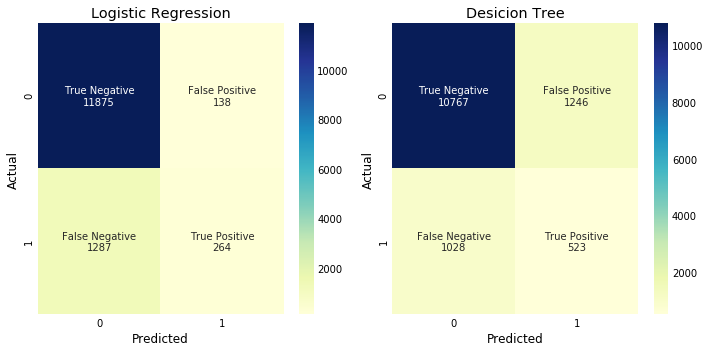

In [36]:
names = ['True Negative','False Positive','False Negative','True Positive']
clf_labels = ['Logistic Regression', 'Desicion Tree']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, (y_pred, model) in enumerate(zip([y_pred_logreg, y_pred_dt], clf_labels)):
    confmat = confusion_matrix(y_test,y_pred)
    counts = ['{0:0.0f}'.format(value) for value in confmat.flatten()] 
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names,counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confmat, annot=labels, fmt='', cmap="YlGnBu", ax=axes[idx])
    axes[idx].set_xlabel("Predicted");
    axes[idx].set_ylabel("Actual");
    axes[idx].set_title(model)

plt.tight_layout()

The logistic regression model has less false positives and more false negatives meaning it has a higher level of precision. Meanwhile the decision tree has more true positives and less false negatives implying better recall. These metrics are summarized below:

In [37]:
model_labels = ['Logistic Regression', 'Decision Tree']

summary_metrics = {
           'Precision':[precision_score(y_test, y_pred_logreg), precision_score(y_test, y_pred_dt)],
           'Recall':[recall_score(y_test, y_pred_logreg), recall_score(y_test, y_pred_dt)],
           'F1':[f1_score(y_test, y_pred_logreg), f1_score(y_test, y_pred_dt)],
           'Roc AUC':[roc_auc_score(y_test, y_proba_logreg), roc_auc_score(y_test, y_proba_dt)],
           'Accuracy':[accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_dt)]
          } 
pd.DataFrame(summary_metrics, index=model_labels).round(2)

,Precision,Recall,F1,Roc AUC,Accuracy
Logistic Regression,0.66,0.17,0.27,0.75,0.89
Decision Tree,0.30,0.34,0.32,0.62,0.83


The logistic regression model is slightly better on accuracy, but the decision tree has a better F1 score which is often the better metric for evaluating preformance when dealing with target class imbalance. The logistic regression, however,  has a better ROC AUC. We can interpret this score as a model's chance of distinguishing between the positive and negative class. So here we can see logistic regression has about a 75% chance of distinguishing between customers who will accept a term deposit and those who will not. The decision tree model only has a 62% chance of making such a distinction.  Finally, we should also note that the logistic regression model has some regularization built into it by default while the decision tree does not which probably explains the overall better performance of the logistic regression model.

<a id="5"></a>
# Step 5: Ensemble Models

In this section we will explore two different ensemble methods, bagging and boosting. For the boosting we will utilize both adaboost and gradient boosting. For each ensemble method we will build two classifiers, one using logistic regression as the base estimator and the other using a decision tree as the base esimator (which is the default estimator of sklearn's ensemble classifiers).

### 5.1 Bagging

In [38]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
print("Training accuracy = {}".format(rf.score(X_train,y_train)))
print("Testing accuracy = {}".format(rf.score(X_test,y_test)))

Training accuracy = 0.9854646569975037
Testing accuracy = 0.8903715718077263


In [39]:
# initialize bagging classifier using decision tree as the base estimator
dtbag = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=1)

# fit the model to the training data
dtbag.fit(X_train, y_train)

# make predictions using the test data
y_pred_dtbag = dtbag.predict(X_test)
y_proba_dtbag = dtbag.predict_proba(X_test)[:, 1]

print("Training accuracy = {}".format(dtbag.score(X_train,y_train)))
print("Testing accuracy = {}".format(dtbag.score(X_test,y_test)))

Training accuracy = 0.9858122412866939
Testing accuracy = 0.8880861102919493


### 5.2 Boosting 
#### 5.2a AdaBoosting

In [40]:
# initialize Adaboost classifier using 50 decision stumps (50 decision trees that each have a maximum depth of 1)
ab = AdaBoostClassifier(random_state=1)

# fit the model to the training data
ab.fit(X_train, y_train)

# make predictions using the test data
y_pred_ab = ab.predict(X_test)
y_proba_ab = ab.predict_proba(X_test)[:, 1]

print("Training accuracy = {}".format(ab.score(X_train,y_train)))
print("Testing accuracy = {}".format(ab.score(X_test,y_test)))

Training accuracy = 0.8916484974879135
Testing accuracy = 0.8930256561486287


#### 5.2b Gradient Boosting

In [41]:
# initialize Gradient Boosting classifier using 100 decision trees that each have a maximum depth of 3 (default)
gb = GradientBoostingClassifier(random_state=1)

# fit the model to the scaled training data
gb.fit(X_train, y_train)

# make predictions using the scaled test data
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

print("Training accuracy = {}".format(gb.score(X_train,y_train)))
print("Testing accuracy = {}".format(gb.score(X_test,y_test)))

Training accuracy = 0.8981262046955477
Testing accuracy = 0.8964907107048068


### 5.3 Performance Measures

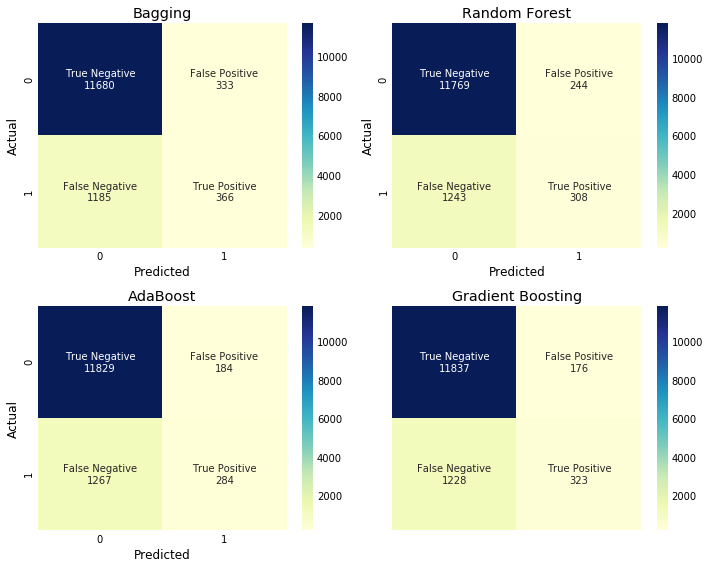

In [42]:
names = ['True Negative','False Positive','False Negative','True Positive']
clf_labels = ['Bagging','Random Forest', 'AdaBoost', 'Gradient Boosting']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for idx, (y_pred, model) in enumerate(zip([y_pred_dtbag,y_pred_rf, y_pred_ab, y_pred_gb], clf_labels)):
    ax = axes.flatten()[idx]
    confmat = confusion_matrix(y_test,y_pred)
    counts = ['{0:0.0f}'.format(value) for value in confmat.flatten()] 
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names,counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confmat, annot=labels, fmt='', cmap="YlGnBu", ax=ax)
    ax.set_xlabel("Predicted");
    ax.set_ylabel("Actual");
    ax.set_title(model)

axes[1,1].set_axis_off()
plt.tight_layout()

In [43]:
ensemble_labels = ['Logistic Regression', 'Decision Tree','Bagging', 'Random Forest','AdaBoost', 'GradientBoosting']
predictions = [y_pred_logreg, y_pred_dt, y_pred_dtbag, y_pred_rf, y_pred_ab, y_pred_gb] # the predictions made by Bagging, AdaBoost, and Gradient Boosting
class_proba = [y_proba_logreg, y_proba_dt, y_proba_dtbag,y_proba_rf, y_proba_ab, y_proba_gb]


ensemble_metrics = {'precision':[precision_score(y_test, y_pred) for y_pred in predictions],
                    'recall':[recall_score(y_test, y_pred) for y_pred in predictions], 
                    'f1':[f1_score(y_test, y_pred) for y_pred in predictions], 
                    'roc_auc':[roc_auc_score(y_test, y_proba) for y_proba in class_proba],
                    'accuracy':[accuracy_score(y_test, y_pred) for y_pred in predictions]
                   } 

pd.DataFrame(ensemble_metrics, index=ensemble_labels).round(2)

,precision,recall,f1,roc_auc,accuracy
Logistic Regression,0.66,0.17,0.27,0.75,0.89
Decision Tree,0.30,0.34,0.32,0.62,0.83
Bagging,0.52,0.24,0.33,0.74,0.89
Random Forest,0.56,0.20,0.29,0.74,0.89
AdaBoost,0.61,0.18,0.28,0.78,0.89
GradientBoosting,0.65,0.21,0.32,0.80,0.90


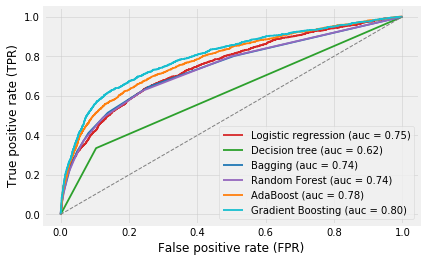

In [44]:
clf_labels = ['Logistic regression', 'Decision tree', 'Bagging', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
colors = ['tab:red', 'tab:green', 'tab:blue','tab:purple','tab:orange', 'tab:cyan']
# linestyles = [':', '--', '-.','-','--']
for clf, label, clr\
        in zip([logreg, dt, dtbag, rf, ab, gb],
               clf_labels, colors):

   
    y_pred = clf.fit(X_train_scaled,
                     y_train).predict_proba(X_test_scaled)[:, 1] # positive class is 1
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linewidth = 1.8,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=1)

plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

Gradient boosting is the best model we have trained. It outperformed all of the other models with respect to AUC and was equal to our better than the other models with respect to the F1 score. At this point we could proceed with hyperparameter tuning of the model before deploying it to a production environment.